Group 🤡 - Anadolu Sigorta Datathon - 3rd Place Solution

## NOTE
In order to show the operability of the steps in the file, a 3-epoch training has been determined. In the normal pipeline we use in the competition, the models are first trained on 2 classes with fewer samples, and then more than one model that takes this training as checkpoint with full data is left for a long training. Later, these models predict on whole data as ensemble. Full-data training is active in the current configuration. For the 2-class specific training mode, some cells must be skipped in the code and places with underdog comments must be enabled in the dataloader.

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from skimage.transform import resize, rotate, AffineTransform, warp
import matplotlib.pyplot as plt

from torchvision import transforms, utils
from tqdm import tqdm
import random
import time
import segmentation_models_pytorch as smp
from torch import nn
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

!ulimit -n 500000

torch.backends.cudnn.benchmark = True

path = "/kaggle/input/datathon-challenge/"
training_img_extension = "Training_Imgs/Training_Imgs/"
training_mask_extension = "Training_Masks/Training_Masks/"
test_img_extension = "Testing_Imgs/Testing_Imgs/"
mask_threshold = 0.8
network_input = 512
device = "cuda"

def rle(img):
    bytes = np.where(img.flatten()==1)[0]
    runs = []
    prev = -2
    for b in bytes:
        if (b>prev+1): runs.extend((b+1, 0))
        runs[-1] += 1
        prev = b

    return ' '.join([str(i) for i in runs])

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    try:
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape).T
    except:
        return np.zeros(shape).T


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-67hoqwsg
     |████████████████████████████████| 58 kB 599 kB/s 
     |████████████████████████████████| 244 kB 1.1 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-py3-none-any.whl size=66501 sha256=ddbe4fca65bcbbda719d9ec926d10940dc19eadb15703584dc5c252f45502456
  Stored in directory: /tmp/pip-ephem-wheel-cache-dtl73rk3/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=adae7c750f11f313c599ee5fd823edb5f8049cb145b84e5337ca20599ee50d38
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=afe4eddab9a0904d19a9d29d53c06b49de7be6ee780d7f6605fb129c83e95313
  Stored in directo

## Dataset

In [2]:
class AnadoluDataset(Dataset):

    def __init__(self, csv_file, root_dir, mask_dir, network_input, idxs, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.selected_class = 2
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.network_input = network_input
        self.landmarks_frame["imgname"]  = self.landmarks_frame["filename_class"].apply(lambda x: x[:-4] + ".jpeg")
        self.landmarks_frame["class_id"]  = self.landmarks_frame["filename_class"].apply(lambda x: int(x[-1]))

        ## UNDERDOG MODE
#         self.underdogs = self.landmarks_frame[(self.landmarks_frame["class_id"].isin([1,2,3,4])) & (self.landmarks_frame["encoded_mask"])]
#         self.uniqframes = self.underdogs["imgname"].unique()
        
        self.uniqframes = self.landmarks_frame["imgname"].unique()[idxs]
        self.landmarks_frame_values = self.landmarks_frame.values
        
    def __len__(self):
        return len(self.uniqframes)

    def __getitem__(self, idx):
        
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.uniqframes[idx])
        image = io.imread(img_name)
        
        img_filter = self.landmarks_frame_values[:,4]==self.uniqframes[idx]
        
        mask_arr = self.landmarks_frame_values[img_filter,1]
        img_width = image.shape[1]
        img_height = image.shape[0]
        shapearr = np.array([img_height, img_width])

        decoded_masks = np.array([rle_decode(mask, (img_width, img_height)) for mask in mask_arr])
        
        returning = {'image': image, 'decoded_masks': decoded_masks, 'shape': shapearr}
        
        if self.transform:
            transformed = self.transform(image=returning["image"], masks=[mask for mask in returning["decoded_masks"]])
            returning["image"] = transformed["image"]
            returning["decoded_masks"] = np.array(transformed["masks"])
            
        return returning
    

aug_trans = A.Compose(
    [
        A.Resize(network_input, network_input),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.15, rotate_limit=40, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.35),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ]
)

dataset = AnadoluDataset(path + "training.csv", 
                         path+training_img_extension, 
                         path+training_mask_extension, 
                         network_input,
                         np.arange(1401),
                         aug_trans
                        )     

val_class_inverse_ratios = torch.FloatTensor(np.ones(4)*0.25).to(device)
train_class_inverse_ratios = torch.FloatTensor(np.ones(4)*0.25).to(device)
class_inverse_ratios = [train_class_inverse_ratios, val_class_inverse_ratios]

# Dataset Class-Imbalance Analysis

In [3]:
train_split_ratio = 0.65

existing_masks = dataset.landmarks_frame[["filename_class","encoded_mask"]].dropna()
namesplit = existing_masks["filename_class"].str.split("_id", n=1, expand=True)

existing_masks["class"] = namesplit[1]
existing_masks["img_unique_id"] = namesplit[0]
existing_masks = existing_masks[["class", "img_unique_id"]]

counts = existing_masks["class"].value_counts().to_dict()

print(counts)

class_pick_order = dict(sorted(counts.items(), key=lambda item: item[1]))
class_pick_order = list(class_pick_order.keys())


train_imgs_after_process = []
val_imgs_after_process = []

for i in class_pick_order:
    
    print("Picking for class", i)
    counts = existing_masks["class"].value_counts().to_dict()
    class_count = counts[i]
    perm = np.random.permutation(class_count)
    
    train_selected_imgs = perm[:int(class_count*train_split_ratio)]
    val_selected_imgs = perm[-int(class_count*(1-train_split_ratio)):]
    
    imgs_for_class = existing_masks[existing_masks["class"]==i]["img_unique_id"].unique()
    train_imgs_for_class = imgs_for_class[train_selected_imgs]
    val_imgs_for_class = imgs_for_class[val_selected_imgs]
    
    for ti in train_imgs_for_class:
        train_imgs_after_process.append(ti)
        
    for vi in val_imgs_for_class:
        val_imgs_after_process.append(vi)
        
    existing_masks = existing_masks[existing_masks["img_unique_id"].isin(train_imgs_for_class)==False]
    existing_masks = existing_masks[existing_masks["img_unique_id"].isin(val_imgs_for_class)==False]

{'3': 765, '1': 694, '2': 311, '4': 181}
Picking for class 4
Picking for class 2
Picking for class 1
Picking for class 3


In [4]:
existing_masks = dataset.landmarks_frame[["filename_class","encoded_mask"]].dropna()
namesplit = existing_masks["filename_class"].str.split("_id", n=1, expand=True)

existing_masks["class"] = namesplit[1]
existing_masks["img_unique_id"] = namesplit[0]
existing_masks = existing_masks[["class", "img_unique_id"]]

val_masks = existing_masks[existing_masks["img_unique_id"].isin(val_imgs_after_process)]
train_masks = existing_masks[existing_masks["img_unique_id"].isin(train_imgs_after_process)]

val_counts = val_masks["class"].value_counts().to_dict()
train_counts = train_masks["class"].value_counts().to_dict()
val_counts = dict(sorted(val_counts.items()))
train_counts = dict(sorted(train_counts.items()))

print("Train set class distribution: ", train_counts)
print("Validation set class distribution: ", val_counts)

total_val_class = sum(list(val_counts.values()))
total_train_class = sum(list(train_counts.values()))

val_class_inverse_ratios = total_val_class / np.array(list(val_counts.values()))
val_class_inverse_ratios = val_class_inverse_ratios / sum(val_class_inverse_ratios)
val_class_inverse_ratios = torch.FloatTensor(val_class_inverse_ratios).to(device)

train_class_inverse_ratios = total_train_class / np.array(list(train_counts.values()))
train_class_inverse_ratios = train_class_inverse_ratios / sum(train_class_inverse_ratios)
train_class_inverse_ratios = torch.FloatTensor(train_class_inverse_ratios).to(device)


print("\nTrain set class weights: ", train_class_inverse_ratios)
print("Validation set class weights: ", val_class_inverse_ratios)

class_inverse_ratios = [train_class_inverse_ratios, val_class_inverse_ratios]
#class_loss_weights = 

Train set class distribution:  {'1': 452, '2': 207, '3': 482, '4': 117}
Validation set class distribution:  {'1': 242, '2': 104, '3': 282, '4': 64}

Train set class weights:  tensor([0.1252, 0.2735, 0.1174, 0.4838], device='cuda:0')
Validation set class weights:  tensor([0.1255, 0.2921, 0.1077, 0.4747], device='cuda:0')


In [5]:
train_idxs = []
val_idxs = []

for ti in train_imgs_after_process:
    train_idxs.append(np.argwhere(dataset.uniqframes==ti+".jpeg")[0][0])

for vi in val_imgs_after_process:
    val_idxs.append(np.argwhere(dataset.uniqframes==vi+".jpeg")[0][0])
    
print("Train set indice length: ", len(train_idxs))
print("Validation set indice length: ", len(val_idxs))


Train set indice length:  911
Validation set indice length:  489


## Visualization

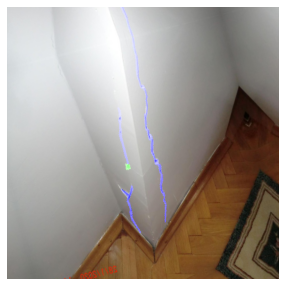

In [6]:
fig = plt.figure(figsize=(15,5))

maskcolors = [[0], [1], [2], [0,1,2]]

i = 1 ## You can iterate through photos with dataset index number

data = dataset[i]
sample = data["image"]
decoded_masks = data["decoded_masks"]

plt.axis('off')

for mask_i, mask in enumerate(decoded_masks):
    try: 
        mask.shape == 1
        mask = mask[..., np.newaxis]

        active_channel = mask[:,:,0]

        mask = np.tile(mask,(1,1,3))
        mask = np.zeros(mask.shape)

        for idx in maskcolors[mask_i]:
            mask[:,:,idx] = active_channel

        masklocs = np.where(mask == 1)
        sample[masklocs] = 255

    except:
        pass

plt.imshow(sample)
plt.show()

## Setting Dataloaders

In [7]:
train_tf_compose = A.Compose(
    [
        A.Resize(network_input, network_input),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.15, rotate_limit=40, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.35),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


train_starting_tf_compose =  A.Compose(
    [
        A.Resize(network_input, network_input),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_tf_compose = A.Compose(
    [
        A.Resize(network_input, network_input),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


train_tf_composes = [train_starting_tf_compose, train_tf_compose]

train_set = AnadoluDataset(path + "training.csv", 
                         path+training_img_extension, 
                         path+training_mask_extension, 
                         network_input,
                         train_idxs,
                         train_starting_tf_compose)
                         
val_set = AnadoluDataset(path + "training.csv", 
                         path+training_img_extension, 
                         path+training_mask_extension, 
                         network_input,
                         val_idxs,
                         val_tf_compose)

In [8]:
bsize = 4

train_dataloader = DataLoader(train_set, batch_size=bsize,
                        shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

val_dataloader = DataLoader(val_set, batch_size=4,
                        shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

In [9]:
for data in val_dataloader:
    print(data.keys())
    print(data["decoded_masks"].shape)
    break

dict_keys(['image', 'decoded_masks', 'shape'])
torch.Size([4, 4, 512, 512])


In [10]:
network = smp.DeepLabV3Plus(
encoder_name="timm-efficientnet-b0",
encoder_weights="imagenet", 
in_channels=3,
classes=4)                     


## FOR TRANSFER LEARNING
# for param in network.encoder.parameters():
#     param.requires_grad = False

## FOR LOADING A CHECKPOINT    
# network = torch.load("kaggle63.pt")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


In [11]:
def train(lr, model, train_dl, valid_dl, loss_fns, acc_fn, epochs=1, out_size=512, train_tf=None, class_inverse_ratios=[0.25, 0.25, 0.25, 0.25]):
    start = time.time()
    model.to(device)
    loss_weights = [.50, .15, .35]
    train_loss, valid_loss = [], []

    best_acc = 0.0
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    epoch_acc = 0
    epoch_acc_to_aug = 0.64
    last_train_loss = 1.
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)
        
        if epoch_acc >= epoch_acc_to_aug:
            train_dl.dataset.transform = train_tf[1]
            print("DICE >=", epoch_acc_to_aug, "!. Transforms enabled.")
        else:
            train_dl.dataset.transform = train_tf[0]
            print("DICE <", epoch_acc_to_aug, "!. Transforms disabled.")
            
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for data in dataloader:
                x = data["image"].float().to(device, non_blocking=True)
                y = data["decoded_masks"].float().to(device, non_blocking=True)
                step += 1

                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = torch.sigmoid(model(x))
                    
                    loss = np.sum([loss_fn(outputs, y, class_inverse_ratios[0]) * loss_weights[loss_i] for loss_i, loss_fn in enumerate(loss_fns)])

                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        outputs = torch.sigmoid(model(x))                            
                        loss = np.sum([loss_fn(outputs, y, class_inverse_ratios[1]) * loss_weights[loss_i] for loss_i, loss_fn in enumerate(loss_fns)])
                    

                o_copy = outputs.detach()
                o_copy[o_copy<mask_threshold] = 0
                o_copy[o_copy>=mask_threshold] = 1
                
                if phase=="train":
                    acc = acc_fn(o_copy, y, class_inverse_ratios[0])
                else:
                    acc = acc_fn(o_copy, y, class_inverse_ratios[1])
                    
                printed_loss = loss
                
                running_acc  += acc*dataloader.batch_size
                running_loss += printed_loss*dataloader.batch_size 

                if step % 25 == 0 and phase=="train":
                    print('Current step: {}  Loss: {} DICE: {} AllocMem (Mb): {}'.format(step, printed_loss, acc, torch.cuda.memory_allocated()/1024/1024))

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            
            if phase == "train":
                train_acc = epoch_acc
                
                if (last_train_loss - epoch_loss) < 0:
                    print("Loss plateu, Decreasing LR")
                    for g in optimizer.param_groups:
                        g['lr'] = g['lr'] / 1.5
                        
                last_train_loss = epoch_loss
                
                
            
            if phase == "valid" and epoch>=0:
                if epoch_acc>best_acc:
                    best_acc = epoch_acc
                    val_dice = "{:.4f}".format(epoch_acc).split(".")[-1]
                    train_dice = "{:.4f}".format(train_acc).split(".")[-1]
                    
                    torch.save(model, "best_val_"+val_dice+"__train_"+train_dice+".pt")
                    print("Saved best val model with DICE: {:.4f}".format(epoch_acc))
            
            
            print('{} Loss: {:.4f}, DICE: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            
            
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    torch.save(model, "model.pt")
    
    return train_loss, valid_loss    

In [12]:
def soft_dice_loss(y_pred, y_true, train_class_inverse_ratios=train_class_inverse_ratios, epsilon=1e-6): 
    
    dims = (1, 2, 3)
    intersection = torch.sum(y_pred * y_true, dims)
    cardinality = torch.sum(y_pred + y_true, dims)

    dice_score = 2. * intersection / (cardinality + epsilon)
    return torch.mean(1. - dice_score)


def dice_score(y_pred, y_true, train_class_inverse_ratios=train_class_inverse_ratios, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    y_pred, y_true = y_pred.permute(0,2,3,1), y_true.permute(0,2,3,1)

    axes = tuple(range(1, len(y_pred.shape)-1)) 
    mult = y_pred * y_true

    numerator = 2. * torch.sum(mult, axis=axes)
    denominator = torch.sum(y_pred + y_true, axes)
    
    return torch.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

def bce_over_mask_loss(y_pred, y_true, train_class_inverse_ratios=train_class_inverse_ratios, network_input_size=network_input): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
    '''
    
    y_pred, y_true = y_pred.permute(0,2,3,1), y_true.permute(0,2,3,1)
    
    bce = nn.BCELoss(reduction="none")
    bceloss = bce(y_pred, y_true)
    
    summation = torch.sum(bceloss, axis=(1,2))
    batch_mean = torch.mean(summation, axis=0)
    mask_mean = torch.sum(batch_mean * train_class_inverse_ratios)
    
    return mask_mean / (network_input_size**2) # average over classes and batch

def tversky(y_pred, y_true, train_class_inverse_ratios, smooth=1, alpha=0.7):

    dims = (0, 2, 3)
    
    true_pos = torch.sum(torch.sum(y_pred * y_true, dims) * train_class_inverse_ratios)
    false_neg = torch.sum(torch.sum((1 - y_pred) * y_true, dims) * train_class_inverse_ratios)
    false_pos = torch.sum(torch.sum((1 - y_true) * y_pred, dims) * train_class_inverse_ratios)
    
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def focal_tversky_loss(y_pred, y_true, train_class_inverse_ratios, gamma=0.75):
    
    tv = tversky(y_true, y_pred, train_class_inverse_ratios)
    return torch.pow((1 - tv), gamma)


In [13]:
loss_fns = [focal_tversky_loss, bce_over_mask_loss, soft_dice_loss]

train_loss, valid_loss = train(1e-3, network, train_dataloader, val_dataloader, loss_fns, dice_score, epochs=3, out_size=network_input, train_tf = train_tf_composes, class_inverse_ratios=class_inverse_ratios)

Epoch 0/2
----------
DICE < 0.64 !. Transforms disabled.
Current step: 25  Loss: 0.8748001456260681 DICE: 0.5677095651626587 AllocMem (Mb): 115.8564453125
Current step: 50  Loss: 0.737671971321106 DICE: 0.6723414063453674 AllocMem (Mb): 115.8564453125
Current step: 75  Loss: 0.8265969157218933 DICE: 0.5533096194267273 AllocMem (Mb): 115.8564453125
Current step: 100  Loss: 0.5559031963348389 DICE: 0.6376137733459473 AllocMem (Mb): 115.8564453125
Current step: 125  Loss: 0.7836527824401855 DICE: 0.4604164958000183 AllocMem (Mb): 115.8564453125
Current step: 150  Loss: 0.8259316086769104 DICE: 0.506971001625061 AllocMem (Mb): 115.8564453125
Current step: 175  Loss: 0.4071674048900604 DICE: 0.8213141560554504 AllocMem (Mb): 115.8564453125
Current step: 200  Loss: 0.743782639503479 DICE: 0.5367636680603027 AllocMem (Mb): 115.8564453125
Current step: 225  Loss: 0.5084253549575806 DICE: 0.6765023469924927 AllocMem (Mb): 115.8564453125
train Loss: 0.6747, DICE: 0.6106
Saved best val model with

# INFERENCE
The models to be used in ensemble prediction are specified in the cell below. In order for the sample code to work, the names of both models are set as the name saved at the end of the train.

In [14]:
supervisor_model = torch.load("model.pt") # 1. model
supervisor_model2 = torch.load("model.pt") # 2. model

trained_models = [supervisor_model, supervisor_model2]

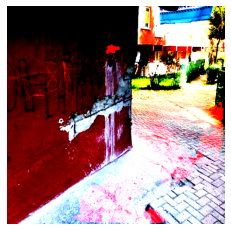

In [15]:
## Trying to show tensor-normalized versions of pictures, colors can appear faulty.

for data in val_dataloader:
    x = data["image"][0:1].cuda()
    y = data["decoded_masks"][0].detach().cpu().numpy()
    shape = data["shape"][0:2]

    outputs = torch.sigmoid(supervisor_model2(x))[0].detach().cpu().numpy()
    
    x = x.cpu().numpy().transpose((0,2,3,1))[0][:,:,:3]
    shapetuple = (shape[1], shape[0])
    fig = plt.figure()

    maskcolors = [[0], [1], [2], [0,1,2]]

    plt.axis('off')

    for mask_i, mask in enumerate(outputs):
        try: 
            mask[mask<mask_threshold] = 0
            mask[mask>=mask_threshold] = 1            
            mask = mask[..., np.newaxis]

            active_channel = mask[:,:,0]
            
            mask = np.tile(mask,(1,1,3))
            mask = np.zeros(mask.shape)

            for idx in maskcolors[mask_i]:
                mask[:,:,idx] = active_channel

            masklocs = np.where(mask == 1)
            x[masklocs] = 1

        except:
            print("ahoy")


    plt.imshow(x)
    plt.show()
    
    break

# DICE Metric Test

In [16]:
def dice_eval(models, dl, loss_fn, mask_threshold=0.75):
    start = time.time()

    valid_loss = [], []

    best_acc = 0.0
    
    for model in models:
        model.cuda()
        model.train(False)

    running_loss = 0.0
    running_acc = 0.0

    step = 0

    for data in tqdm(dl):
        x = data["image"].cuda()
        y = data["decoded_masks"].cuda()
        step += 1

        with torch.no_grad():
            
            outputs_sup = torch.sigmoid(models[0](x))
            outputs_sup2 = torch.sigmoid(models[1](x))
            
            ## Weights are determined via 1 layer blender NN
            
            outputs_sup[:,1,:,:] *= 0.1 # yeşil class
            outputs_sup[:,0,:,:] *= 0.85 # kırmızı class
            outputs_sup[:,2,:,:] *= 0.5 # mavi class
            outputs_sup[:,3,:,:] *= 0.15 # beyaz class
    
            outputs_sup2[:,1,:,:] *= 0.9 # yeşil class
            outputs_sup2[:,0,:,:] *= 0.15 # kırmızı class
            outputs_sup2[:,2,:,:] *= 0.5 # mavi class
            outputs_sup2[:,3,:,:] *= 0.85 # beyaz class
            
            outputs = outputs_sup + outputs_sup2

            outputs[outputs<mask_threshold] = 0
            outputs[outputs>=mask_threshold] = 1
            
            beyazfinder = torch.where(outputs[0,3] == 1)
            tempp = torch.ones((outputs.shape[2], outputs.shape[3])).cuda()
            tempp[beyazfinder] = 0
            outputs[:,:3] *= tempp

            loss = loss_fn(outputs, y)

        running_loss += loss*dl.batch_size 

    epoch_loss = running_loss / len(dl.dataset)

    print('Validation DICE Score: {:.4f}'.format(epoch_loss))

    time_elapsed = time.time() - start
    
    print('Validation completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

In [17]:
dice_eval(trained_models, val_dataloader, dice_score, mask_threshold)

100%|██████████| 122/122 [00:37<00:00,  3.25it/s]

Validation DICE Score: 0.6796
Validation completed in 0m 38s


In [18]:
class AnadoluTestDataset(Dataset):

    def __init__(self, csv_file, root_dir, network_input, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.network_input = network_input
        self.landmarks_frame["imgname"]  = self.landmarks_frame["filename_class"].apply(lambda x: x[:-4] + ".jpeg")
        self.uniqframes = self.landmarks_frame["imgname"].unique()
        
    def __len__(self):
        return len(self.uniqframes)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.uniqframes[idx])
        image = io.imread(img_name)
        
        img_filter = self.landmarks_frame["imgname"]==self.uniqframes[idx]
        img_width = image.shape[1]
        img_height = image.shape[0]
        img_name_wo_class = self.uniqframes[idx][:-5]
        
        returning = {'image': image, 'shape': np.array([img_height, img_width]), 'imgname': img_name_wo_class}
        
        if self.transform:
            transformed = self.transform(image=returning["image"])
            returning["image"] = transformed["image"]
            
            
        return returning

In [19]:
test_transform = A.Compose(
    [
        A.Resize(network_input, network_input),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_dataset = AnadoluTestDataset(path + "sample_submission.csv", 
                         path+test_img_extension, 
                         network_input,
                         test_transform
                        )     

test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=False, num_workers=0)

In [20]:
def create_csv(models, dl, mask_threshold=0.75):
    start = time.time()
    for model in models:
        model.cuda()
        model.train(False)

    data_arr = []
    
    for data in tqdm(dl):
 
        x = data["image"].float().to(device, non_blocking=True)
        shape = data["shape"].int().view(x.shape[0], 2)
        imgnames = data["imgname"]
        
        with torch.no_grad():

            outputs_sup = torch.sigmoid(models[0](x)).cpu().numpy()
            outputs_sup2 = torch.sigmoid(models[1](x)).cpu().numpy()
            
            ## 1-layer NN ile belirlenip yuvarlanmış katsayılar, sunumda bahsedilecek
            
            outputs_sup[:,1,:,:] *= 0.1 # yeşil class
            outputs_sup[:,0,:,:] *= 0.85 # kırmızı class
            outputs_sup[:,2,:,:] *= 0.5 # mavi class
            outputs_sup[:,3,:,:] *= 0.15 # beyaz class
    
            outputs_sup2[:,1,:,:] *= 0.9 # yeşil class
            outputs_sup2[:,0,:,:] *= 0.15 # kırmızı class
            outputs_sup2[:,2,:,:] *= 0.5 # mavi class
            outputs_sup2[:,3,:,:] *= 0.85 # beyaz class
            
            outputs = outputs_sup + outputs_sup2

            outputs[outputs<mask_threshold] = 0
            outputs[outputs>=mask_threshold] = 1
            
            beyazfinder = np.where(outputs[0,3] == 1)
            tempp = np.ones((outputs.shape[2], outputs.shape[3]))
            tempp[beyazfinder] = 0
            outputs[:,:3] *= tempp
            
        for bid in range(outputs.shape[0]):
            shapetuple = shape[bid]
            
            for mid in range(outputs.shape[1]):
                iname_row = imgnames[bid] + "_id" + str(mid+1)            
                resized_out = F.resize(outputs[bid][mid], height=shapetuple[0], width=shapetuple[1], interpolation=cv2.INTER_NEAREST).T
                encoded_row = rle(resized_out)
                data_arr.append([iname_row, encoded_row])

    time_elapsed = time.time() - start
    
    df = pd.DataFrame(data_arr, columns=['filename_class', 'encoded_mask'])

    print('CSV completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    
    return df

In [21]:
trained_models = [supervisor_model, supervisor_model2]
csvdf = create_csv(trained_models, test_dataloader, mask_threshold=mask_threshold)

100%|██████████| 503/503 [01:24<00:00,  5.97it/s]

CSV completed in 1m 24s


In [22]:
samplesub = pd.read_csv(path + "sample_submission.csv")
cropped_csvdf = csvdf[csvdf['filename_class'].isin(samplesub["filename_class"].values)]
cropped_csvdf.to_csv("sub_ensemble_final.csv", index=None)
csvdf.to_csv("full_test_masks_ensemble_final.csv", index=None)